In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<!---# Objectives:

We want to look at bandits where the rewards are only 1 or 0 (Bernouilli).


1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret. 

3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  
Play with the c parameter in UCB.

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

5) What are your conclusions in terms of methods? Give some intution.



In [66]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [67]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # choose action based on decision rule
        self.iteration += 1 
        if self.decision_rule == "greedy":
            # q_estimate corresponds to the estimated value of each action (action-value function)
            # selected_action corresponds to the action associated to the optimal value
            selected_action = np.argmax(self.q_estimate)

        if self.decision_rule == "epsilon-greedy":
            # Choose a random action with probability epsilon
            if np.random.rand() < self.epsilon:
                # Any actions
                selected_action = np.random.choice(self.actions)
            
            # Otherwise choose the greedy action
            else:
                selected_action = np.argmax(self.q_estimate)
        
        if self.decision_rule == "UCB":
            # Confidence level corresponds to the exploration term
            confidence_lvl = np.sqrt(2*np.log(self.iteration) / (self.act_count))
            
            # Argument which maximize the UCB
            selected_action = np.argmax(self.q_estimate + self.UCB_param * confidence_lvl)

        self.act_count[selected_action] += 1
        return selected_action

In [68]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=2000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    #initp = array of probabilities of each arm
    #initq = array of initial values for each arm
    #repetitions = number of repetitions
    #N = number of steps per repetition
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [69]:
def plot_results(agents, actions, rewards):
    
    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i], label=agent.decision_rule)
        ax[1].plot(np.cumsum(rewards[i]), label=agent.decision_rule)
        ax[2].plot(actions[i], label=agent.decision_rule)

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()
    
    

/tmp/ipykernel_869/327397094.py:58: RuntimeWarning: invalid value encountered in divide
  confidence_lvl = np.sqrt(2*np.log(self.iteration) / (self.act_count))
/tmp/ipykernel_869/327397094.py:58: RuntimeWarning: divide by zero encountered in divide
  confidence_lvl = np.sqrt(2*np.log(self.iteration) / (self.act_count))


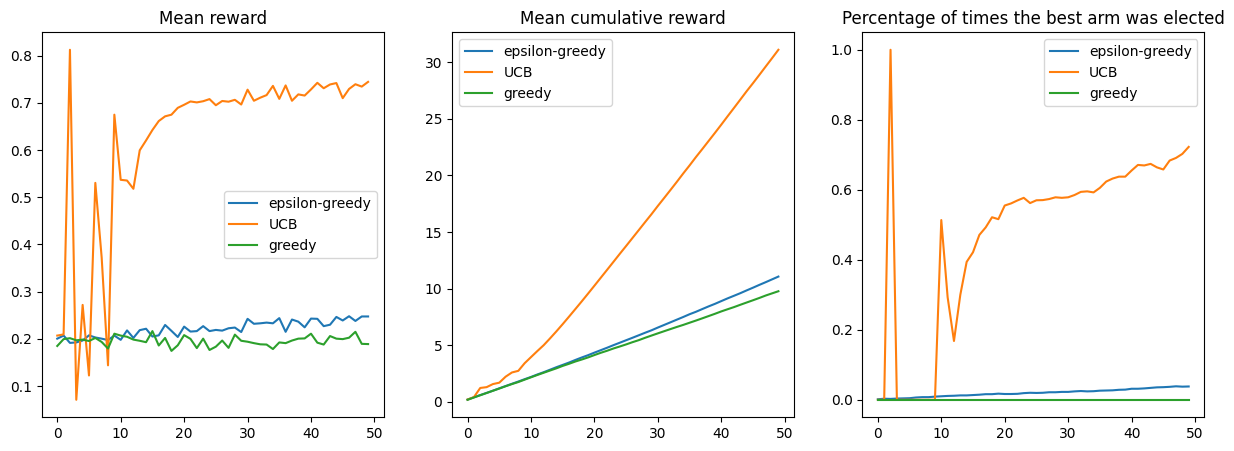

In [70]:
# Number of arms
narms = 10

# Number of repetitions
N = 2000

# Number of steps per repetition
T = 50

# Probability of each arm
p = np.random.uniform(size=narms)
# p = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]

# Initial values for the q estimates and consider optimistic greedy
# q_init = np.ones(narms)
q_init = np.zeros(narms)

# Agents
agent1 = Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": 0.01})

agent2 = Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param": 0.3})

agent3 = Agent(learning_rule="BayesianBetaPrior", decision_rule="greedy")

list_agents = [agent1, agent2, agent3]
[rewards, actions] = simulateBandits(list_agents, narms=narms, initp=p, repetitions=N, N=T)

plot_results(list_agents, actions, rewards)


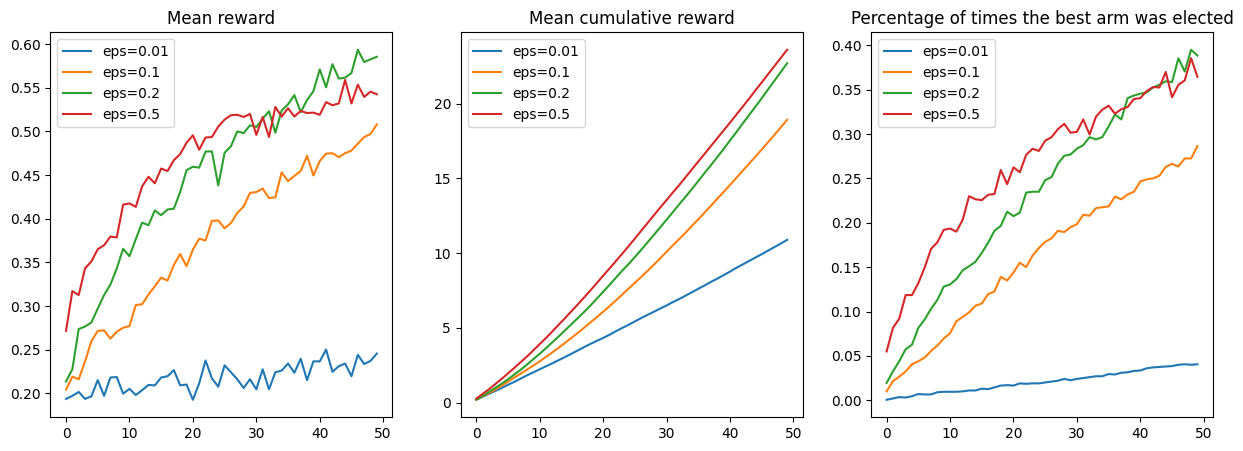

In [71]:
def plot_results_fordiffepsilon(agents, list, actions, rewards):
    
    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i], label="eps="+str(list[i]))
        ax[1].plot(np.cumsum(rewards[i]), label="eps="+str(list[i]))
        ax[2].plot(actions[i], label="eps="+str(list[i]))

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    plt.show()
    
    

list_epsilon = [0.01, 0.1, 0.2, 0.5]

list_agents_eps = []
for epsilon in list_epsilon:
    agent = Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon": epsilon})
    list_agents_eps.append(agent)
    
[rewards_eps, actions_eps] = simulateBandits(list_agents_eps, narms=narms, initp=p, repetitions=N, N=T)

plot_results_fordiffepsilon(list_agents_eps, list_epsilon, actions_eps, rewards_eps)

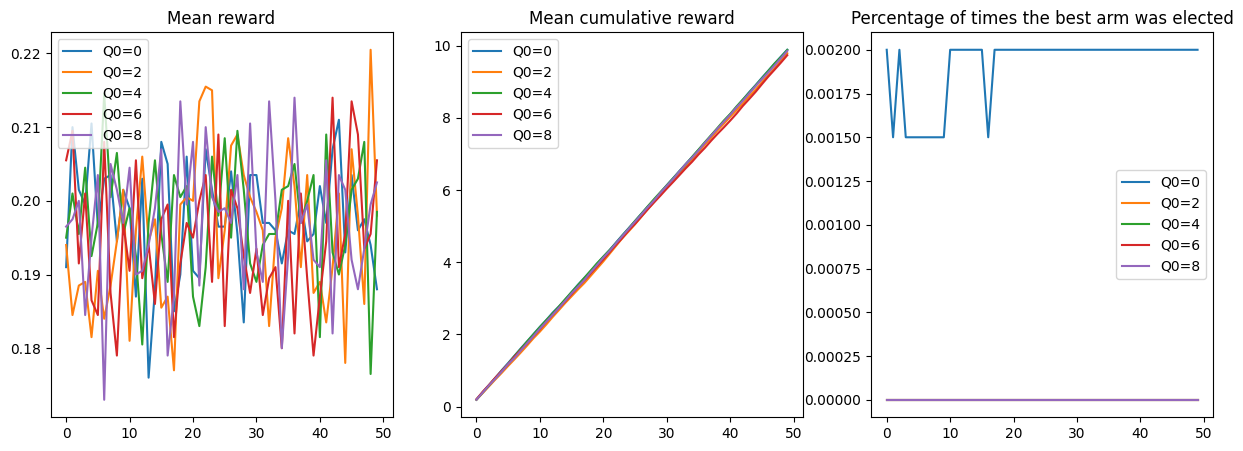

In [72]:
def simulateBandits_qinit(agents, narms, initp=None, initq=None, repetitions=2000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    #initp = array of probabilities of each arm
    #initq = array of initial values for each arm
    #repetitions = number of repetitions
    #N = number of steps per repetition
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq.all() == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

def plot_results_qinit(agents, list, actions, rewards):
    
    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i], label="Q0="+str(list[i]))
        ax[1].plot(np.cumsum(rewards[i]), label="Q0="+str(list[i]))
        ax[2].plot(actions[i], label="Q0="+str(list[i]))

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()

list_value = [0, 2, 4, 6, 8]
list_agents_qinit = []
for value in list_value:
    q_init = np.zeros(narms)
    q_init.fill(value)
    agent5 = Agent(learning_rule="averaging", decision_rule="greedy")
    list_agents_qinit.append(agent5)

[rewards_qinit, actions_qinit] = simulateBandits_qinit(list_agents_qinit, narms=narms, initp=p, initq=q_init, repetitions=N, N=T)

plot_results_qinit(list_agents_qinit, list_value, actions_qinit, rewards_qinit)

In [73]:
# Gradient bandits and consider a reward of 4 instead of 1

class GradientBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(4, p=self.p[action])
   
class GradientAgent(object):
    def __init__(self, num_actions, alpha=0.1, baseline=False):
        self.num_actions = num_actions
        self.alpha = alpha
        self.action_preferences = np.zeros(num_actions)
        self.action_probabilities = np.exp(self.action_preferences) / np.sum(np.exp(self.action_preferences))
        self.baseline = baseline
        self.iteration = 0
        if baseline:
            self.name = "Gradient Bandit (alpha = " + str(self.alpha) + ", R_bar = 4 * max(p))"
        else:
            self.name = "Gradient Bandit (alpha = " + str(self.alpha) + ", R_bar = 0)"

    def learn(self, chosen_action, reward):
        for action in range(self.num_actions):
            if self.baseline:
                R_bar = 4 * max(self.action_probabilities)
            else:
                R_bar = 0
            
            if action == chosen_action:
                self.action_preferences[action] += self.alpha * (reward - R_bar) * (1 - self.action_probabilities[action])
            else:
                self.action_preferences[action] -= self.alpha * (reward - R_bar) * self.action_probabilities[action]
        
        self.action_probabilities = np.exp(self.action_preferences) / np.sum(np.exp(self.action_preferences))

    def act(self):
        self.iteration += 1
        return np.random.choice(self.num_actions, p=self.action_probabilities)

In [74]:
def simulateBandits2(agents, narms, initp=None, repetitions=2000, N=100):
    # Function that simulates the agents' behavior.
    # `agents` is a list of agents.

    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))

    for i, agent in enumerate(agents):
        for j in range(repetitions):
            rewards_sum = 0
            environment = GradientBanditEnv(num_arms=narms, p=initp)
            agent = GradientAgent(narms)  # Initialize the GradientAgent within the loop
            
            for n in range(N):
                a = agent.act()
                r = environment.reward(a)  # Use the environment's reward function
                agent.learn(a, r)  # Update agent's preferences based on rewards
                
                rewards_sum += r
                rewards[i, j, n] = rewards_sum / (n + 1)  # Average reward up to this point
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))



In [75]:
def plot_results2(agents, actions, rewards):
    
    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.
    list = ["without baseline", "with baseline"]
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i], label=list[i])
        ax[1].plot(np.cumsum(rewards[i]), label=list[i])
        ax[2].plot(actions[i], label=list[i])

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()
    
    

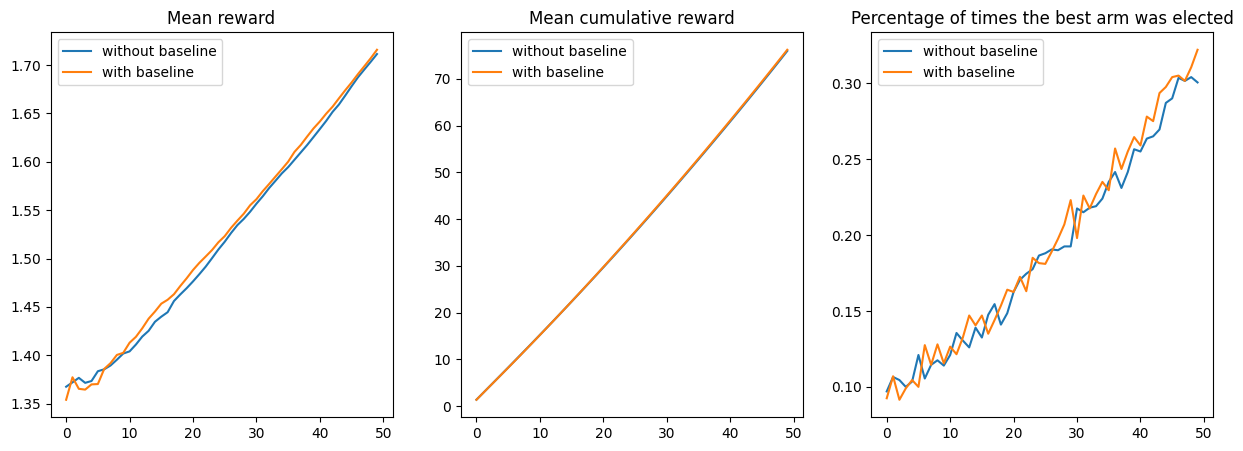

In [76]:
alpha = [1]
baselines = [False, True]

agents = [GradientAgent(num_actions=narms, alpha=alpha, baseline=baseline) for alpha in alpha for baseline in baselines]

[rewards2, actions2] = simulateBandits2(agents, narms=narms, initp=p, repetitions=N, N=T)

plot_results2(agents, actions2, rewards2)

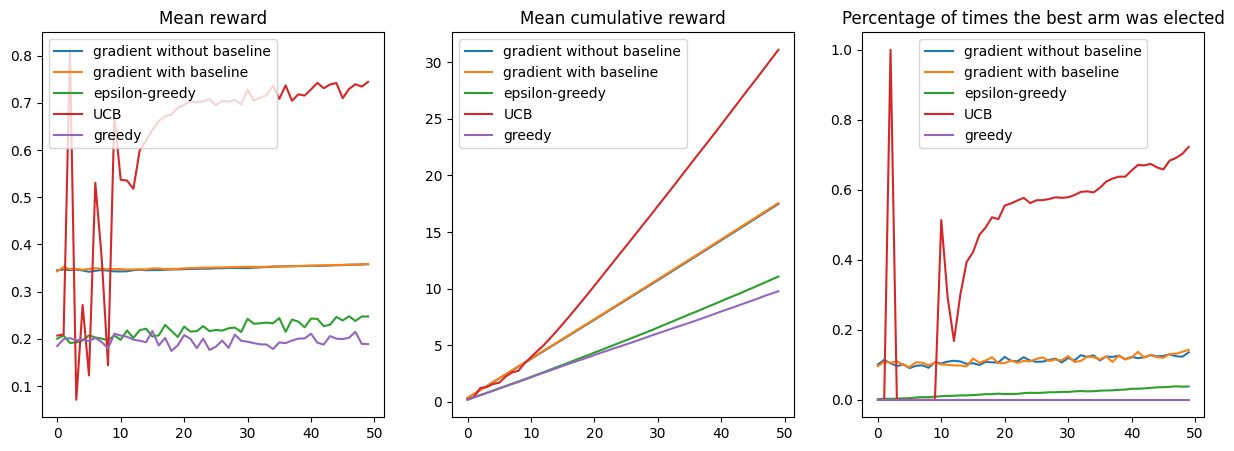

In [77]:
# Gradient bandits and consider a reward of 4 instead of 1

class GradientBanditEnv3(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])
   
class GradientAgent3(object):
    def __init__(self, num_actions, alpha=0.1, baseline=False):
        self.num_actions = num_actions
        self.alpha = alpha
        self.action_preferences = np.zeros(num_actions)
        self.action_probabilities = np.exp(self.action_preferences) / np.sum(np.exp(self.action_preferences))
        self.baseline = baseline
        self.iteration = 0
        if baseline:
            self.name = "Gradient Bandit (alpha = " + str(self.alpha) + ", R_bar = 4 * max(p))"
        else:
            self.name = "Gradient Bandit (alpha = " + str(self.alpha) + ", R_bar = 0)"

    def learn(self, chosen_action, reward):
        for action in range(self.num_actions):
            if self.baseline:
                R_bar = 4 * max(self.action_probabilities)
            else:
                R_bar = 0
            
            if action == chosen_action:
                self.action_preferences[action] += self.alpha * (reward - R_bar) * (1 - self.action_probabilities[action])
            else:
                self.action_preferences[action] -= self.alpha * (reward - R_bar) * self.action_probabilities[action]
        
        self.action_probabilities = np.exp(self.action_preferences) / np.sum(np.exp(self.action_preferences))

    def act(self):
        self.iteration += 1
        return np.random.choice(self.num_actions, p=self.action_probabilities)
    

def simulateBandits3(agents, narms, initp=None, repetitions=2000, N=100):
    # Function that simulates the agents' behavior.
    # `agents` is a list of agents.

    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))

    for i, agent in enumerate(agents):
        for j in range(repetitions):
            rewards_sum = 0
            environment = GradientBanditEnv3(num_arms=narms, p=initp)
            agent = GradientAgent(narms)  # Initialize the GradientAgent within the loop
            
            for n in range(N):
                a = agent.act()
                r = environment.reward(a)  # Use the environment's reward function
                agent.learn(a, r)  # Update agent's preferences based on rewards
                
                rewards_sum += r
                rewards[i, j, n] = rewards_sum / (n + 1)  # Average reward up to this point
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

alpha = [1]
baselines = [False, True]

agents_gradient = [GradientAgent3(num_actions=narms, alpha=alpha, baseline=baseline) for alpha in alpha for baseline in baselines]

[rewards_gradient, actions_gradient] = simulateBandits3(agents_gradient, narms=narms, initp=p, repetitions=N, N=T)

def plot_results_5(agents, actions, rewards):
    
    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.
    list = ["gradient without baseline", "gradient with baseline"]
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        if i < 2 : 
            ax[0].plot(rewards[i], label=list[i])
            ax[1].plot(np.cumsum(rewards[i]), label=list[i])
            ax[2].plot(actions[i], label=list[i])
        else:
            ax[0].plot(rewards[i], label=agent.decision_rule)
            ax[1].plot(np.cumsum(rewards[i]), label=agent.decision_rule)
            ax[2].plot(actions[i], label=agent.decision_rule)

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()
    
    
list5 = agents_gradient + list_agents 
actions5 = np.concatenate((actions_gradient, actions), axis=0)
rewards5 = np.concatenate((rewards_gradient, rewards), axis=0)
plot_results_5(list5, actions5, rewards5)

## Partie 3

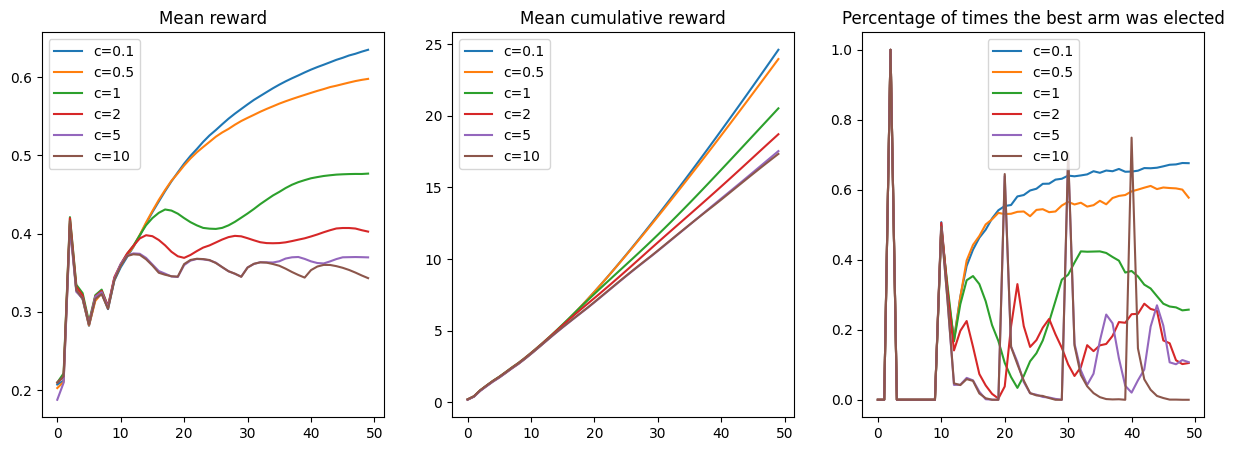

In [78]:
# Plot the UCB agent with different c values

class UCB_Agent(object):

    def __init__(self, num_actions, c):
        self.num_actions = num_actions
        self.c = c
        self.action_values = np.zeros(num_actions)
        self.action_counts = np.zeros(num_actions)
        self.iteration = 0
        self.name = "UCB (c = " + str(self.c) + ")"

    def learn(self, chosen_action, reward):
        self.action_counts[chosen_action] += 1
        self.action_values[chosen_action] += (reward - self.action_values[chosen_action]) / self.action_counts[chosen_action]

    def act(self):
        self.iteration += 1
        if self.iteration <= self.num_actions:
            return self.iteration - 1
        else:
            ucb_values = self.action_values + self.c * np.sqrt(np.log(self.iteration) / self.action_counts)
            return np.argmax(ucb_values)
        
def simulateBandits(agents, narms, initp=None, repetitions=2000, N=100):

    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))

    for i, ag in enumerate(agents):
        for j in range(repetitions):
            rewards_sum = 0
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent = UCB_Agent(narms, ag)  # Initialize the UCB_Agent within the loop
            
            for n in range(N):
                a = agent.act()
                r = environment.reward(a)  # Use the environment's reward function
                agent.learn(a, r)  # Update agent's preferences based on rewards
                
                rewards_sum += r
                rewards[i, j, n] = rewards_sum / (n + 1)  # Average reward up to this point
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

def plot_results_c(agents, list, actions, rewards):

    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.


    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i], label="c="+str(list[i]))
        ax[1].plot(np.cumsum(rewards[i]), label="c="+str(list[i]))
        ax[2].plot(actions[i], label="c="+str(list[i]))

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()
    
    

c_values = [0.1, 0.5, 1, 2, 5, 10]
agents = [c for c in c_values]

[rewards3, actions3] = simulateBandits(agents, narms=narms, initp=p, repetitions=N, N=T)

plot_results_c(agents, c_values, actions3, rewards3)

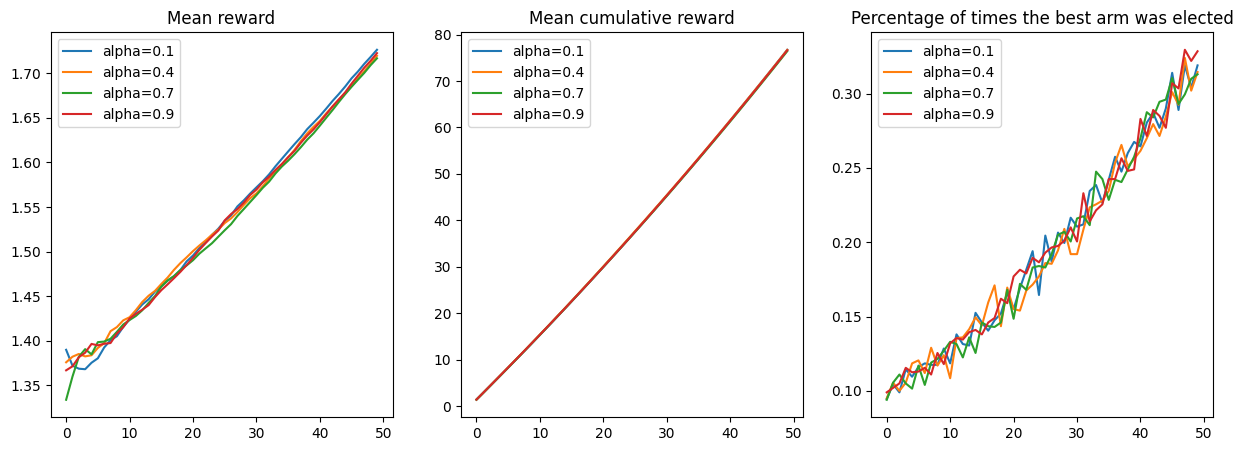

In [79]:
# Plot the gradient agent with different alpha values

def plot_results_alpha(agents, list, actions, rewards):

    #Plot the corresponding mean reward; 
    # the mean cumulative reward and 
    # the percentage of times the best arm was elected as time goes by.


    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, agent in enumerate(agents):
        ax[0].plot(rewards[i], label="alpha="+str(list[i]))
        ax[1].plot(np.cumsum(rewards[i]), label="alpha="+str(list[i]))
        ax[2].plot(actions[i], label="alpha="+str(list[i]))

    ax[0].set_title('Mean reward')
    ax[1].set_title('Mean cumulative reward')
    ax[2].set_title('Percentage of times the best arm was elected')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()

alpha_values = [0.1, 0.4, 0.7, 0.9]

agents = [alpha for alpha in alpha_values]

[rewards4, actions4] = simulateBandits2(agents, narms=narms, initp=p, repetitions=N, N=T)

plot_results_alpha(agents, alpha_values, actions4, rewards4)


In [80]:
# The best algorithm among epsilon greedy, ucb, gradient bandit and optimistic greedy algorithm is the UCB algorithm with c = 1. Indeed, it is the algorithm that has the best mean reward and the best mean cumulative reward. However, the percentage of times the best arm was elected is better for the optimistic greedy algorithm. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward 
# and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward. The optimistic greedy algorithm is the algorithm that has the best percentage of times the best arm was elected. However, it is not the best algorithm because it has the worst mean reward and the worst mean cumulative reward. The epsilon greedy algorithm is the algorithm that has the worst percentage of times the best arm was elected. The gradient bandit algorithm is the algorithm that has the worst mean reward and the worst mean cumulative reward.

# We can say that the shape of the curves of the UCB algorithm is the best. Indeed, the mean reward and the mean cumulative reward increase with the number of iterations. The shape of the curves of the optimistic greedy algorithm is the worst. Indeed, the mean reward and the mean cumulative reward decrease with the number of iterations. The shape of the curves of the epsilon greedy algorithm and the gradient bandit algorithm are similar. Indeed, the mean reward and the mean cumulative reward increase with the number of iterations and then decrease with the number of iterations.
# The optimal parameter in each of the algorithms is the following:
# - epsilon greedy: epsilon = 0.1
# - UCB: c = 1
# - Gradient bandit: alpha = 0.1
# - Optimistic greedy: q0 = 8
